In [107]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc


In [127]:
def get_roc_auc(file):
    dmp = torch.load(file)
    y_test, y_score = dmp['tar'],dmp['pred']
    y_score = torch.log_softmax(y_score, dim=-1)
    n_classes = y_score.shape[-1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        target_arr = (y_test == i).numpy().astype(int)
        fpr[i], tpr[i], _ = roc_curve(target_arr, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) * 100
    return fpr, tpr, roc_auc

In [128]:
orig_fpr, orig_tpr, orig_roc_auc = get_roc_auc('./data/original.pt')
fpr_3s, tpr_3s, roc_auc_3s = get_roc_auc('./data/3s_crops.pt')
fpr_5s, tpr_5s, roc_auc_5s = get_roc_auc('./data/5s_crops.pt')
fpr_7s, tpr_7s, roc_auc_7s = get_roc_auc('./data/7s_crops.pt')


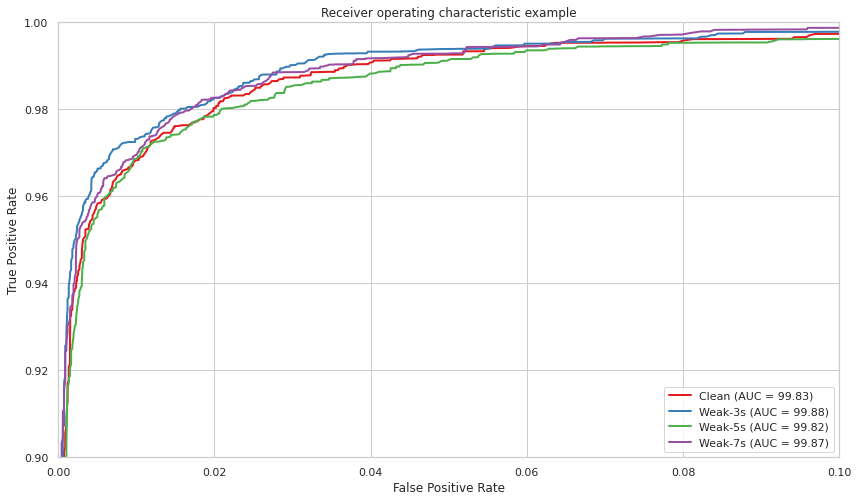

In [131]:
sns.set(palette='Set1', style='whitegrid')
plt.figure(figsize=(14,8))
lw = 2
plt.plot(
    orig_fpr['macro'],
    orig_tpr['macro'],
#     color="darkorange",
    lw=lw,
    label="Clean (AUC = %1.2f)" % orig_roc_auc['macro'],
)
plt.plot(
    fpr_3s['macro'],
    tpr_3s['macro'],
#     color="blue",
    lw=lw,
    label="Weak-3s (AUC = %1.2f)" % roc_auc_3s['macro'],
)
plt.plot(
    fpr_5s['macro'],
    tpr_5s['macro'],
#     color="green",
    lw=lw,
    label="Weak-5s (AUC = %1.2f)" % roc_auc_5s['macro'],
)
plt.plot(
    fpr_7s['macro'],
    tpr_7s['macro'],
#     color="black",
    lw=lw,
    label="Weak-7s (AUC = %1.2f)" % roc_auc_7s['macro'],
)
# plt.plot([0, 0.1], [0, 0.1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('roc_auc.pdf', bbox_inches='tight')
plt.show()